# PSP SPAN-Ion Velocity Distribution Function (VDF) Plotting Tutorial

Greetings! Below is a guide to plotting proton velocity-space distribution functions (VDFs) from the PSP SPAN-I instrument. If one is only interested in viewing a VDF at a particular time, the reader may skip to cell (blank).

We note that the SPAN-I instrument has many caveats and the data remains preliminary due to ongoing calibration work done by the instrument team. 

For optimal scientific interpretation of noteworthy event, the reader is strongly encouraged to contact a member of the instrument team:<br>
Roberto Livi rlivi@berkeley.edu <br>
Ali Rahmati rahmati@berkeley.edu <br>
Michael McManus mdmcmanus@berkeley.edu <br>
Davin Larson davin@berkeley.edu <br>

This tutorial was brought to you by: <br>
Jaye Verniero jaye.l.verniero@nasa.gov <br>
Kristoff Paulson kristoff.paulson@cfa.harvard.edu <br>
who may serve as points of contact for this tutorial. <br>

The paper describing the SPAN-I instrument in more detail can be found here: <br>https://doi.org/10.3847/1538-4357/ac93f5

This tutorial mirrors the SPAN-e plotting walkthrough found here: https://github.com/kpaulson/PSPGatewayHelp/blob/master/JupyterNotebook_Tutorials/PSP/SPANe_pitchAngleWalkthrough/PSP_SPANe_PitchAnglePlotter%20-%20PythonTutorial.ipynb
where the user can also learn about cdf files.

## Step 0

First, we import the cdf reader from cdflib (the library able to read the data encoded in the cdf format) and wget (which we will use here to grab and download the file from the remote server). We also import 'numpy' for math operations and 'datetime' for time unit conversions.

In [39]:
#!pip install wget
import wget
import cdflib
import numpy as np
from datetime import datetime
import os.path
import bisect
import matplotlib.pyplot as plt

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

## Step 1

Let's download the data!

In [9]:
year=2020
month=1
day=29

user_datetime = datetime(year,month,day)

def yyyymmdd(dt) : return f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

#Import from file directory
VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{yyyymmdd(user_datetime)}_v04.cdf'

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(VDfile_filename):
    print(f"File already exists in local directory - [{VDfile_filename}]")
    VDfile = VDfile_filename
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

File already exists in local directory - [psp_swp_spi_sf00_L2_8Dx32Ex8A_20200129_v04.cdf]


Now, we open the cdf file and look at the variables along with their associated structure.

In [10]:
#open CDF file
dat = cdflib.CDF(VDfile)

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


## Step 2
Let's define some variables!

In [11]:
epoch_ns           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

Type which timeslice you would like to plot in the format (year, month, day, hour, minute, second)

As of now, it is set up to input a single day, but future iterations of this tutorial will implement a time range. 

In [17]:
#convert time
datetime_t0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))

hour = 18
minute = 10
second = 2

timeSlice  = datetime.datetime(year, month, day, hour, minute, second)
print('Desired timeslice:',timeSlice)

#find index for desired timeslice
tSliceIndex  = bisect.bisect_left(epoch,timeSlice)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:06.095190


Now define all variables at this time slice. 

In [18]:
epochSlice  = epoch[tSliceIndex]
thetaSlice  = theta[tSliceIndex,:]
phiSlice    = phi[tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[tSliceIndex,:]

And now we rearrange to a more readable format reflecting 8 $\phi$-direction bins, 32 energy bins, and 8 $\theta$-direction bins. Note that the $\phi$ direction is partially obstructed by the heat shield, and therefore should be treated with extra caution (and ideally guidance from the instrument team).

In [19]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


## Step 3
Now that we downloaded the data and defined the variables in the most optimal format, we are ready to begin our journey toward plotting a VDF.

In [20]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

Next, rotate from energy-angle space to cartesian (vx,vy,vz) space (still in the SPAN-I instrument frame):

In [21]:
vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vz = vel *                                   np.sin(np.radians(thetaReshaped))

First, we plot the collapsed distribition function f(v), where all angles are summed as an approximation.

Text(0.5, 0, 'Velocity (km/s)')

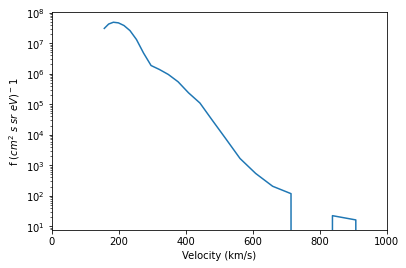

In [40]:
#sum over both phi and theta 
vdf_allAngles = np.sum(vdf, axis=(0,2))

#plot and set limits/labels
plt.plot(vel[0,:,0],vdf_allAngles)
plt.yscale('log')
plt.xlim(0,1000)
plt.ylabel(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')
plt.xlabel('Velocity (km/s)')


Now, instead of collapsing all angles, we can sum over individual axes.

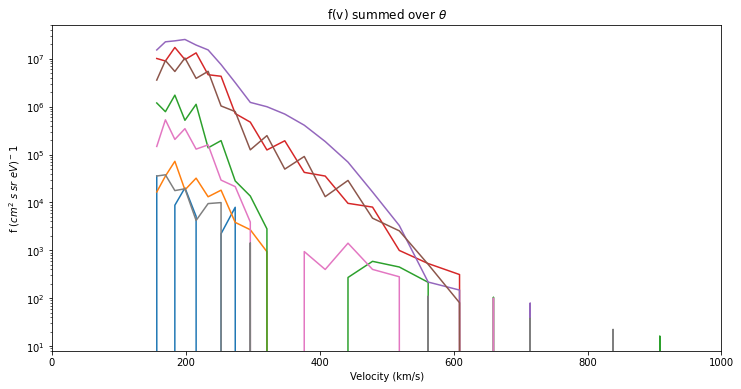

In [41]:
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\\theta$');


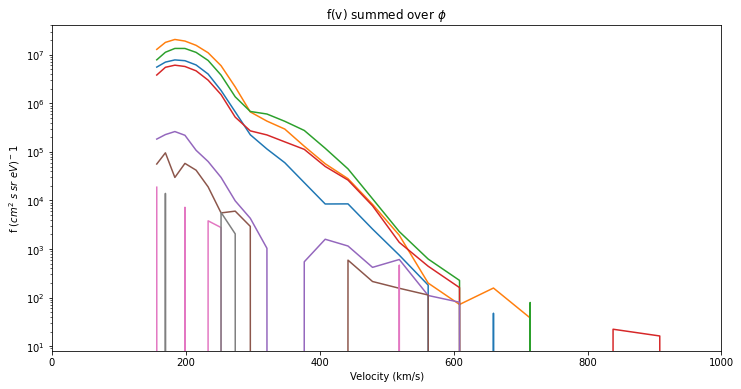

In [43]:
vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\phi$');


An alternative way to represent this data is to produce 2D contour plots through cuts in the $\theta$ and $\phi$ planes.

Text(0.5, 1.0, 'VDF SPAN-I $\\theta$-plane')

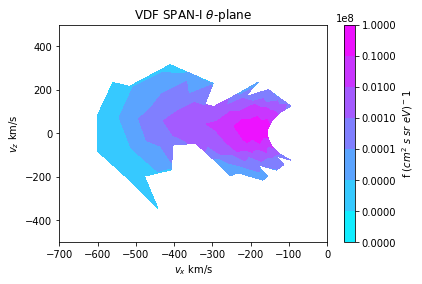

In [64]:
#theta is along dimension 0, while phi is along 2
#first cut through theta

phi_plane = phiReshaped[0,:,:]
theta_plane = thetaReshaped[0,:,:]
energy_plane = energyReshaped[0,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df=np.nansum(vdf,axis=0)


vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_z$ km/s')
ax.set_title('VDF SPAN-I $\\theta$-plane')

Text(0.5, 1.0, 'VDF SPAN-I $\\phi$-plane')

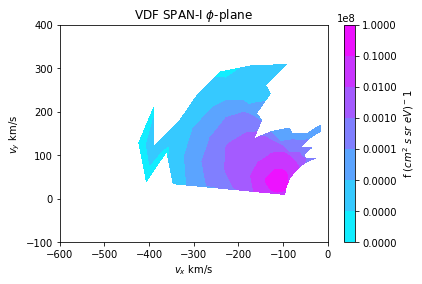

In [67]:
#now repeat for phi dimension

phi_plane = phiReshaped[:,:,0]
theta_plane = thetaReshaped[:,:,0]
energy_plane = energyReshaped[:,:,0]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df=np.nansum(vdf,axis=2)

vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(np.transpose(vx_plane), np.transpose(vy_plane), np.transpose(df),locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-600,0)
ax.set_ylim(-100,400)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_y$ km/s')
ax.set_title('VDF SPAN-I $\\phi$-plane')

Notice that not all of the VDF is plotted. This is because the $\phi$ plane is most obstructed by the heat shield. One could use this visualization as a way to determine whether SPAN-I has sufficient field-of-view (FOV) for reliable measurements. One can see in this particular time slice, most of the "core" of the distribution is present, i.e. there exists a peak at the solar wind velocity around -150 km/s. 

# Magnetic Field-Aligned-Coordinates

This visualization of the VDF is in SPAN-I instrument coordinates. To extract more physical meaning, we can rotate to magnetic field-aligned coordinates (FAC) to plot the VDF in ($\mathbf{v}_\parallel$,$\mathbf{v}_\perp$) coordinate space. Here, the perpendcular and parallel directions are with respect to the mean magentic field direction, $\mathbf{B}_0$. Since the magnetic field data is at a much higher cadence than SPAN-I measures the plasma, we can define $\mathbf{B}_0$ as the magnetic field vector rotated into the SPAN-I instrument frame averaged over the 7s cadence of SPAN-I. For this step, we download the L3 SPAN-I data, which contains $\mathbf{B}_0$ in the SPAN-I instrument frame. In general, data analysis is more reliable when we perform computations in the SPAN-I instrument frame to mitigate FOV effects.

In [69]:
#Download L3 plasma moment data
#Import from file directory
MOMfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L3/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
MOMfile_filename = f'psp_swp_spi_sf00_L3_mom_{yyyymmdd(user_datetime)}_v04.cdf'

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(MOMfile_filename):
    print(f"File already exists in local directory - [{MOMfile_filename}]")
    MOMfile = MOMfile_filename
else:
    print("File doesn't exist. Downloading ...")
    MOMfile = wget.download(MOMfile_directoryRemote + MOMfile_filename)


File doesn't exist. Downloading ...


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [66]:
#open plasma moment CDF file
#print variable names in CDF files
MOMdat = cdflib.CDF(MOMfile)

print(MOMdat._get_varnames())
cdf_MOMfile=MOMdat
#check variable formats in cdf file
print(cdf_MOMfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'GAP', 'QUALITY_FLAG', 'DENS', 'VEL_INST', 'VEL_SC', 'VEL_RTN_SUN', 'T_TENSOR_INST', 'TEMP', 'EFLUX_VS_ENERGY', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI', 'ENERGY_VALS', 'THETA_VALS', 'PHI_VALS', 'SUN_DIST', 'VENUS_DIST', 'SC_VEL_RTN_SUN', 'QUAT_SC_TO_RTN', 'MAGF_SC', 'MAGF_INST', 'ROTMAT_SC_INST'])


The following is a description of each variable: <br>
QUALITY FLAG - Data quality indicator <br>
DENS - Density (1/cm^3)<br>
VEL_INST - Velocity in SPAN-I instrument coordinates (km/s) <br>
VEL_SC - Spacecraft Velocity (km/s)<br>
VEL_RTN_SUN - Ion Velocity in RTN coordinates (km/s)<br>
TEMP - Ion Temperature (eV)<br>
T_TENSOR_INST - Temperature Tensor SPAN-I instrument coordinates <br>
EFLUX_VS_ENERGY - Proton Differential Energy Flux vs eV <br>
EFLUX_VS_THETA - Proton Differential Energy Flux vs Theta (deflectors)<br>
EFLUX_VS_PHI - Proton Differential Energy Flux vs Phi (anodes)<br>
SUN-DIST - Distance from Sun (km)<br>
VENUS-DIST - Distance from Venus (km)
SC_VEL_RTN- Spacecraft Velocity in RTN coordinates (km/s)<br>
QUAT_SC_TO_RTN - Quaternion rotation of spacecraft in RTN coordinates<br>
MAGF_SC - Magnetic field downsampled to SPAN_I time resolution in spacecraft coordinates (nT)<br>
MAGF_INST - Magnetic field downsampled to SPAN_I time resolution in SPAN-I instrument coordinates (nT)<br>

Specific details on these variables will be left for a future tutorial. An existing one to get started using PySPEDAS is located here: <br>
https://github.com/jlverniero/PSP_Data_Analysis_Tutorials/blob/main/PSP_data_tutorial_pyspedas.ipynb

For now, we are interested in only the MAGF-INST variable.

In [68]:
#Define variables

epoch_nsMOM = cdf_MOMfile['Epoch']
B_SPAN = cdf_MOMfile['MAGF_INST']

#====================================================
#Match timeslice 
#This step may or may not be necessary

#epochMOM = np.array([datetime_t0 + datetime.timedelta(seconds=i/1e9) for i in epoch_nsMOM])
#tSliceIndexMOM  = bisect.bisect_left(epochMOM,timeSlice)
#print(epochMOM[tSliceIndexMOM])
#print(epoch[tSliceIndex])
#print(tSliceIndexMOM)


B_SPANslice = B_SPAN[tSliceIndex,:]

if B_SPANslice.ndim == 2:
    Bx_SPAN = B_SPANslice[:,0]
    By_SPAN = B_SPANslice[:,1]
    Bz_SPAN = B_SPANslice[:,2]
elif B_SPANslice.ndim == 1:
    Bx_SPAN = B_SPANslice[0]
    By_SPAN = B_SPANslice[1]
    Bz_SPAN = B_SPANslice[2]

NameError: name 'cdf_MOMfile' is not defined

Now that we have the magnetic field direction in the SPANi instrument coordinates, we can rotate the processed data into field-aligned coordinates. We will define two processes here below, one of which will output the elements of a rotation matrix from instrument to field-aligned coordinates (made up of the three unit vectors defining those coordinates), and another which will rotate an input vector from instrument to field-aligned coordinates.

This process will make several assumptions, the largest being that the magnetic field is perfectly defined by each measurement over the course of the SPANi collection period. 

(Future Work: The field measurment can be defined at each anode measurement time for each sub-frame of SPANi data, but we would have to use the merged FGM-SCM data product and better pinpoint the timestamps on each submeasurement of the instrument.)

In [68]:
def fieldAlignedCoordinates(Bx, By, Bz):
    '''
    INPUTS:
         Bx, By, Bz = rank1 arrays of magnetic field measurements in instrument frame
    '''
    import numpy as np


    Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)

    # Define field-aligned vector
    Nx = Bx/Bmag
    Ny = By/Bmag
    Nz = Bz/Bmag

    # Make up some unit vector
    if np.isscalar(Nx):
        Rx = 0
        Ry = 1.
        Rz = 0
    else:
        Rx = np.zeros(Nx.len())
        Ry = np.ones(len(Nx))
        Rz = np.zeros(len(Nx))

    # Find some vector perpendicular to field NxR 
    TEMP_Px = ( Ny * Rz ) - ( Nz * Ry )  # P = NxR
    TEMP_Py = ( Nz * Rx ) - ( Nx * Rz )  # This is temporary in case we choose a vector R that is not unitary
    TEMP_Pz = ( Nx * Ry ) - ( Ny * Rx )


    Pmag = np.sqrt( TEMP_Px**2 + TEMP_Py**2 + TEMP_Pz**2 ) #Have to normalize, since previous definition does not imply unitarity, just orthogonality
  
    Px = TEMP_Px / Pmag # for R=(0,1,0), NxR = P ~= RTN_N
    Py = TEMP_Py / Pmag
    Pz = TEMP_Pz / Pmag


    Qx = ( Pz * Ny ) - ( Py * Nz )   # N x P
    Qy = ( Px * Nz ) - ( Pz * Nx )  
    Qz = ( Py * Nx ) - ( Px * Ny )  

    return(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)


# ###
# ### TRANSFORM VECTOR DATA INTO FIELD-ALIGNED COORDINATES
# ###

def rotateVectorIntoFieldAligned(Ax, Ay, Az, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz):
    # For some Vector A in the SAME COORDINATE SYSTEM AS THE ORIGINAL B-FIELD VECTOR:

    An = (Ax * Nx) + (Ay * Ny) + (Az * Nz)  # A dot N = A_parallel
    Ap = (Ax * Px) + (Ay * Py) + (Az * Pz)  # A dot P = A_perp (~RTN_N (+/- depending on B), perpendicular to s/c y)
    Aq = (Ax * Qx) + (Ay * Qy) + (Az * Qz)  # 

    return(An, Ap, Aq)


Now we will run the data selected earlier in the tutorial through the rotation subprocesses

(32, 8)
(32, 8)


Text(0.5, 1.0, 'VDF SPAN-I instrument coordinates')

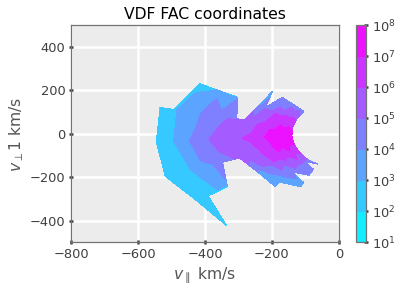

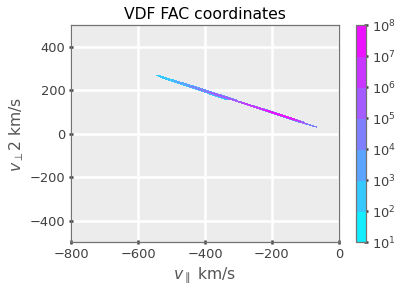

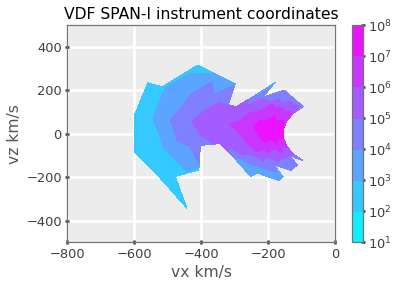

In [71]:
(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(Bx_SPAN, By_SPAN, Bz_SPAN)

(vn_plane, vp_plane, vq_plane) = rotateVectorIntoFieldAligned(vx_plane, vy_plane, vz_plane, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)


print(vn_plane.shape)
print(vp_plane.shape)

fig,ax=plt.subplots()
cs=ax.contourf(vn_plane, vp_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_\parallel$ km/s')
ax.set_ylabel('$v_\perp1$ km/s')
ax.set_title('VDF FAC coordinates')

fig,ax=plt.subplots()
cs=ax.contourf(vn_plane, vq_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_\parallel$ km/s')
ax.set_ylabel('$v_\perp2$ km/s')
ax.set_title('VDF FAC coordinates')

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)
ax.set_xlabel('vx km/s')
ax.set_ylabel('vz km/s')
ax.set_title('VDF SPAN-I instrument coordinates')


Text(0.5, 1.0, 'VDF sphere coordinates')

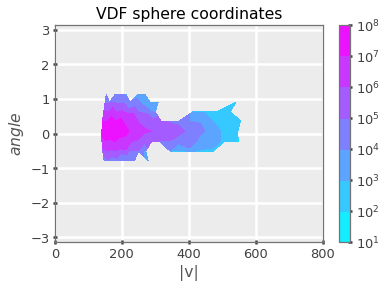

In [100]:
#angle_sphere = np.arctan2(vn_plane,vp_plane)
#vmag_sphere = np.sqrt(vp_plane**2+vn_plane**2)

#fig,ax=plt.subplots()
#cs=ax.contourf(vmag_sphere,angle_sphere, df,locator=ticker.LogLocator(),cmap=cm.cool)
#cbar = fig.colorbar(cs)
#ax.set_xlim(0,800)
# ax.set_ylim(-3.14159,3.14159)
# ax.set_xlabel('|v|')
# ax.set_ylabel('$angle$')
# ax.set_title('VDF sphere coordinates')


angle_sphere = np.arctan(vp_plane/vn_plane)
vmag_sphere = np.sqrt(vp_plane**2+vn_plane**2)


fig,ax=plt.subplots()
cs=ax.contourf(vmag_sphere,angle_sphere, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(0,800)
ax.set_ylim(-3.14159,3.14159)
ax.set_xlabel('|v|')
ax.set_ylabel('$angle$')
ax.set_title('VDF spherical coordinates')



Now we can put it all together into a single plotting script where all we input is the timestamp:

In [21]:


def doitall(timeslice):

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(VDfile_filename):
                print("Version {version} exists")
                VDfile = VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)
                    versionTest = 'found'
                    print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timeslice:',timeslice)
    import bisect
    tSliceIndex  = bisect.bisect_left(epoch, timeslice)
    print('time Index:',tSliceIndex)
    print('Time of closest data point:',epoch[tSliceIndex])

    epochSlice  = epoch[tSliceIndex]
    thetaSlice  = theta[tSliceIndex,:]
    phiSlice    = phi[tSliceIndex,:]
    energySlice = energy[tSliceIndex,:]
    efluxSlice  = eflux[tSliceIndex,:]

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-800,0)
    ax.set_ylim(-500,500)
    ax.set_title(epoch[tSliceIndex].isoformat(timespec='seconds'))



Version {version} exists
Desired timeslice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:06.095191
Grabbed version 04
Desired timeslice: 2021-01-20 03:47:08
time Index: 3898
Time of closest data point: 2021-01-20 03:47:08.511719


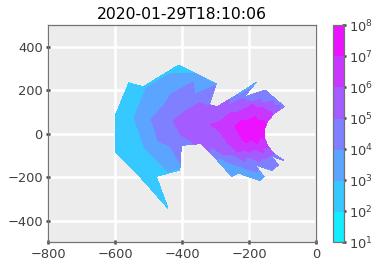

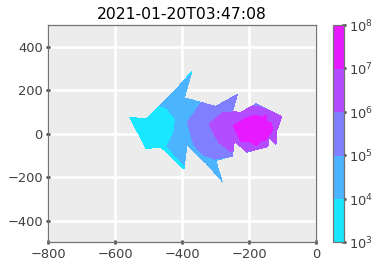

In [22]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice
#timeSlice  = datetime.datetime(2021, 1, 20, 2, 14, 31)   

doitall(timeSlice)
#timeSlice  = datetime.datetime(2021, 1, 20, 4, 57, 38)   # Period of high trat?
timeSlice  = datetime.datetime(2021, 1, 20, 3, 47, 8)   # Period of high trat?
doitall(timeSlice)

In [23]:


def doitallRange(timeStart, timeEnd):

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    timeslice = timeStart
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(VDfile_filename):
                print("Version {version} exists")
                VDfile = VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)
                    versionTest = 'found'
                    print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timerange:',timeStart, ' to ', timeEnd)
    import bisect
    tSliceIndex_start  = bisect.bisect_left(epoch, timeStart)
    tSliceIndex_end    = bisect.bisect_right(epoch, timeEnd)
    tSliceIndex = tSliceIndex_start+int((tSliceIndex_end-tSliceIndex_start)/2.)
    print('time Index Start:',tSliceIndex_start)
    print('time Index End:',tSliceIndex_end)
    print('Time of closest start data point:',epoch[tSliceIndex_start])
    print('Time of closest end data point:',epoch[tSliceIndex_end])

    print(timeEnd - timeStart)
    epochSlice  = epoch[tSliceIndex]
    print(epochSlice)
    thetaSlice  = theta[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    phiSlice    = phi[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    energySlice = energy[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    efluxSlice  = eflux[tSliceIndex_start:tSliceIndex_end].mean(axis=0)

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-800,0)
    ax.set_ylim(-500,500)
    ax.set_title(str(epoch[tSliceIndex].isoformat(timespec='seconds'))+f' +/- {(timeEnd - timeStart)}')



Version {version} exists
Desired timerange: 2021-01-20 02:14:30  to  2021-01-20 02:14:40
time Index Start: 2308
time Index End: 2311
Time of closest start data point: 2021-01-20 02:14:31.044514
Time of closest end data point: 2021-01-20 02:14:41.530296
0:00:10
2021-01-20 02:14:34.539815


AttributeError: module 'matplotlib.cm' has no attribute 'turbo'

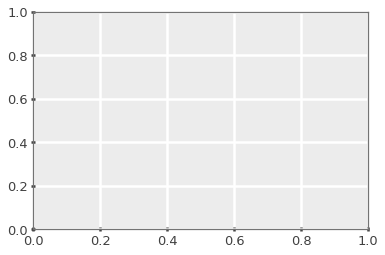

In [24]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
#timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice

timeStart  = datetime.datetime(2021, 1, 20, 2, 14, 30)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 3, 48, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 5, 0, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 20, 30, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 21, 0, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)